In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os
import glob

<h2> Objective </h2>

In [ ]:
pd.set_option("display.max_rows", 500)
pd.set_option("display.max_columns", 200)

In [ ]:
files_tsv = glob.glob("drive/**/*.tsv", recursive=True)
assert len(files_tsv) > 0 , "Files missing in our data"
amazon_data = pd.read_csv(files_tsv[0], sep="\t")

In [ ]:
print("Shape {}".format(amazon_data.shape))

Shape (3150, 5)


<h2> Explanatory Data analysis </h2>

In [ ]:
amazon_data.head()

,rating,date,variation,verified_reviews,feedback
0,5,31-Jul-18,Charcoal Fabric,Love my Echo!,1
1,5,31-Jul-18,Charcoal Fabric,Loved it!,1
2,4,31-Jul-18,Walnut Finish,"Sometimes while playing a game, you can answer...",1
3,5,31-Jul-18,Charcoal Fabric,I have had a lot of fun with this thing. My 4 ...,1
4,5,31-Jul-18,Charcoal Fabric,Music,1


In [ ]:
amazon_data["feedback"].value_counts(normalize=True)

1    0.918413
0    0.081587
Name: feedback, dtype: float64

In [ ]:
amazon_data.describe()

,rating,feedback
count,3150.000000,3150.000000
mean,4.463175,0.918413
std,1.068506,0.273778
min,1.000000,0.000000
25%,4.000000,1.000000
50%,5.000000,1.000000
75%,5.000000,1.000000
max,5.000000,1.000000


In [ ]:
amazon_data["variation"].nunique()

16

In [ ]:
100*amazon_data["variation"].value_counts(normalize=True)

Black  Dot                      16.380952
Charcoal Fabric                 13.650794
Configuration: Fire TV Stick    11.111111
Black  Plus                      8.571429
Black  Show                      8.412698
Black                            8.285714
Black  Spot                      7.650794
White  Dot                       5.841270
Heather Gray Fabric              4.984127
White  Spot                      3.460317
White                            2.888889
Sandstone Fabric                 2.857143
White  Show                      2.698413
White  Plus                      2.476190
Oak Finish                       0.444444
Walnut Finish                    0.285714
Name: variation, dtype: float64

In [ ]:
amazon_data.describe(include="object")

,date,variation,verified_reviews
count,3150,3150,3150
unique,77,16,2301
top,30-Jul-18,Black Dot,
freq,1603,516,79


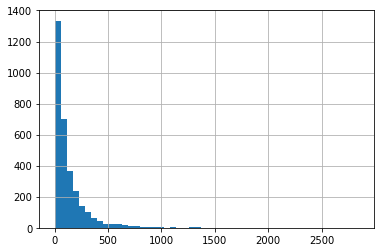

In [ ]:
# let's calculate the length of text
%matplotlib inline
amazon_data["verified_reviews"].apply(len).hist(bins=50)

In [ ]:
len(amazon_data["verified_reviews"].drop_duplicates())

2301

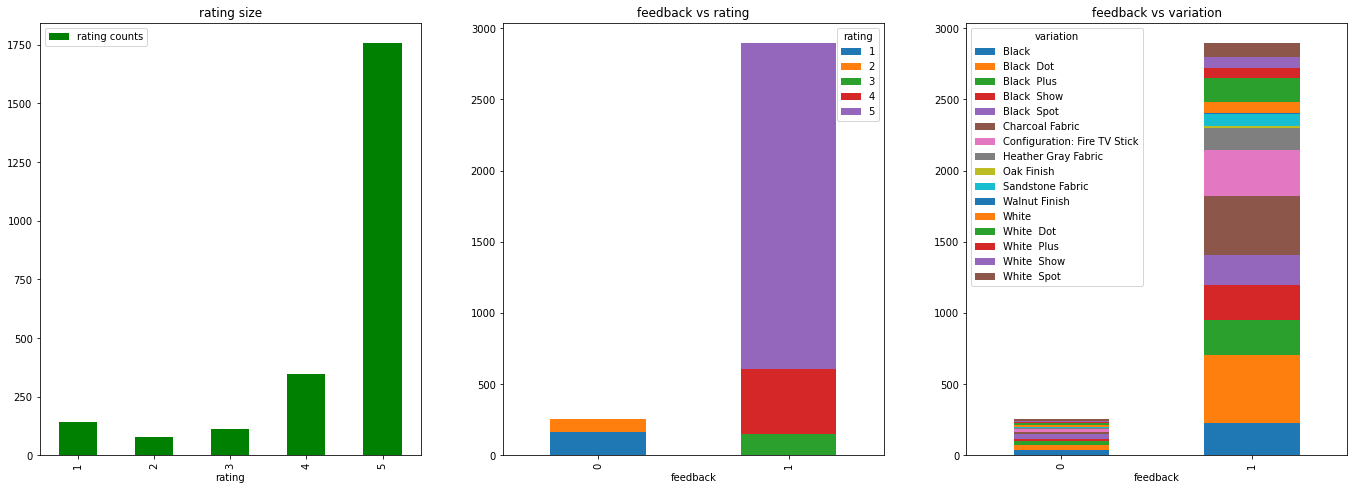

In [ ]:
fig , ax = plt.subplots(1, 3, figsize = (20,8))

df_rating = amazon_data.drop_duplicates().groupby(by="rating", as_index=False).size()
df_rating_feed = amazon_data.groupby(by=["feedback", "rating"])["verified_reviews"].count().unstack('rating')
df_rating_var = amazon_data.groupby(by=["feedback", "variation"])["verified_reviews"].count().unstack("variation")

df_rating.plot(x="rating", y="size", kind="bar", label="rating counts", ax=ax[0], color="green")
df_rating_feed.plot.bar(stacked=True,  ax=ax[1])
df_rating_var.plot.bar(stacked=True, ax=ax[2])
ax[2].set_title("feedback vs variation")
ax[1].set_title("feedback vs rating")
ax[0].set_title("rating size")
plt.tight_layout(pad=5.0)

<h2> Check zipf's law application</h2>

In [ ]:
from collections import Counter
from functools import reduce
from operator import add
from nltk.tokenize import TreebankWordTokenizer
import re

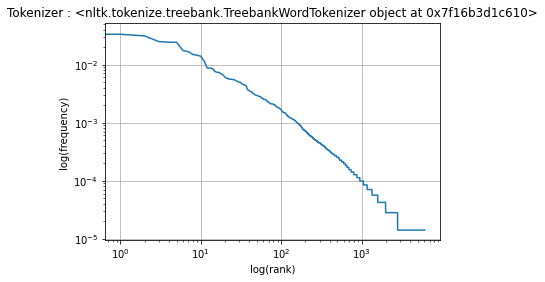

In [ ]:
tok = TreebankWordTokenizer()
arr = amazon_data["verified_reviews"].drop_duplicates().apply(lambda x: tok.tokenize(x)).array
arr = reduce(add, arr)
c = Counter(arr)

d = pd.DataFrame(c, index=['occurrences']).transpose().reset_index()
d.columns=['word', 'occurences']

nb_total = d.occurences.sum()
d['freq'] = d.occurences.apply(lambda x: x/nb_total)

d = d.sort_values('freq', ascending=False)
plt.figure()
plt.grid()
plt.xscale('log')
plt.yscale('log')
plt.xlabel('log(rank)')
plt.ylabel('log(frequency)')
plt.title("Tokenizer : {0}".format(tok))
x = list(range(d.shape[0]))
plt.plot(x, d.freq)
plt.show()

<h2> Retrieve (ints, floats and years) and display its distribution </h2>

In [ ]:
pattern_ints = re.compile("[+-]?(?<![\d.])[0-9]+(?![\d.])")

pattern_floats = re.compile("[+-]?([0-9]*[.])?[0-9]+")

pattern_percentage = re.compile("[+-]?([0-9]*[.])?[0-9]+%")

In [ ]:
df1 = amazon_data.drop_duplicates('verified_reviews') 
progs = [pattern_ints, pattern_floats, pattern_percentage]
nb_types = ['ints', 'floats', 'percents']
for prog, nb_type in zip(progs, nb_types):
  df1[nb_type] = df1['verified_reviews'].apply(lambda x: len(prog.split(x))-1).array
df1[nb_types].head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


,ints,floats,percents
0,0,0,0
1,0,0,0
2,0,0,0
3,1,2,0
4,0,0,0


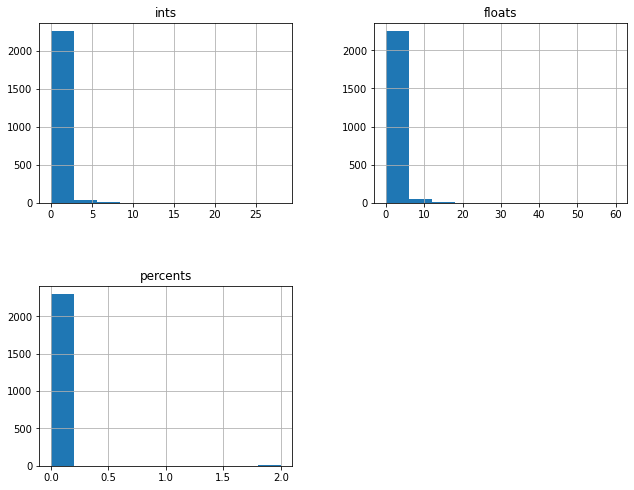

In [ ]:
df1[nb_types].hist(figsize=(10,8))
plt.tight_layout(pad=5.0)

<h2> Sentiment Analysis  explanatory<h2>

In [ ]:
from textblob import TextBlob
import string
import nltk
from sklearn.feature_extraction.text import CountVectorizer
import seaborn as sns
from wordcloud import WordCloud
from nltk.corpus import stopwords
from nltk import pos_tag

from gensim.models import LdaModel
from gensim import corpora
import spacy
from pprint import pprint

In [ ]:
nltk.download("punkt")
nltk.download('averaged_perceptron_tagger')
nltk.download("stopwords")
nltk.download('wordnet')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [ ]:
# let's calculate the polarity of reviiews
def get_polarity(text):
  text_blob = TextBlob(str(text.encode("utf-8")))
  polarity = text_blob.sentiment.polarity
  return polarity

#Let's calcultate the subjectivity of the reviews
def get_subjectivity(text):
  text_blob = TextBlob(str(text.encode("utf-8")))
  subjectivity = text_blob.sentiment.subjectivity
  return subjectivity

In [ ]:
df = pd.DataFrame()
df["polarity"] = amazon_data["verified_reviews"].apply(get_polarity)
df["subjectivity"] = amazon_data["verified_reviews"].apply(get_subjectivity)

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


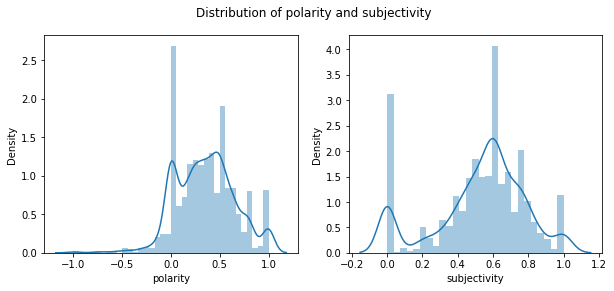

In [ ]:
plt.rcParams["figure.figsize"] = (10, 4)

plt.subplot(1, 2, 1)
sns.distplot(df["polarity"])

plt.subplot(1, 2, 2)
sns.distplot(df["subjectivity"])

plt.suptitle("Distribution of polarity and subjectivity")
plt.show()

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


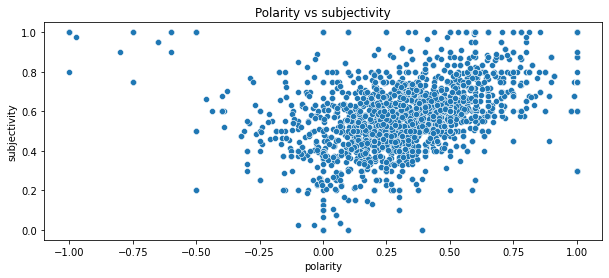

In [ ]:
# Lets check relation between polarity and subjectivity
sns.scatterplot(df["polarity"], df["subjectivity"])
plt.title("Polarity vs subjectivity")
plt.show()

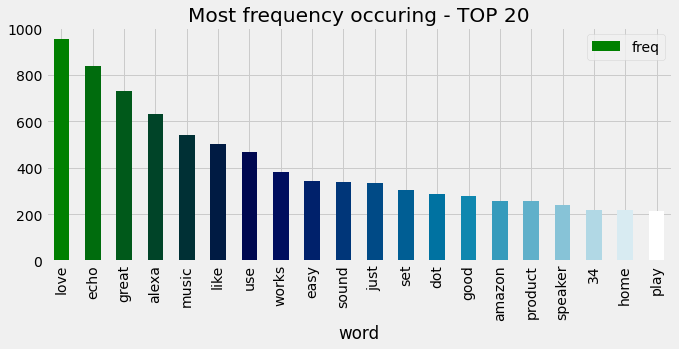

In [ ]:
cv = CountVectorizer(stop_words="english")
words = cv.fit_transform(amazon_data.verified_reviews)
sum_words = words.sum(axis=0)

words_freq =  [(word, sum_words[0, idx]) for word, idx in cv.vocabulary_.items()]

words_freq = sorted(words_freq, key=lambda r:r[1], reverse=True)

frequency = pd.DataFrame(words_freq, columns=["word", "freq"])

plt.style.use("fivethirtyeight")
color = plt.cm.ocean(np.linspace(0, 1, 20))
frequency.head(20).plot(x="word", y="freq", kind="bar", color=color)
plt.title("Most frequency occuring - TOP 20")
plt.show()

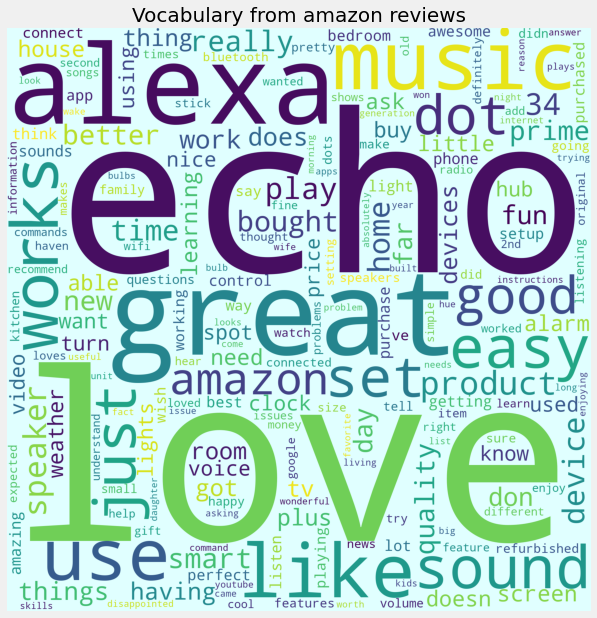

In [ ]:
words_cloud = WordCloud(background_color="lightcyan", width=2000, height=2000).generate_from_frequencies(dict(words_freq))
plt.figure(figsize=(10, 10))
plt.axis("off")
plt.imshow(words_cloud)
plt.title("Vocabulary from amazon reviews", fontsize=20)
plt.show()

<h2 style="text-align=center; font-family=bold;"> Cleaning the data </h2>


In [ ]:
def text_preprocessing(text):
  text = text.lower()
  text = re.sub("[%s]" % re.escape(string.punctuation), ' ', text)
  text = re.sub("https*\S+", ' ', text)
  text = re.sub("@\S+", ' ', text)
  text = re.sub("#\S+", ' ', text)
  text = re.sub("[’]", "'", text)
  text = re.sub("[']\w+", "",text)
  text = re.sub("\w*\d+\w*", '', text)
  text = re.sub("\s{2,}", ' ', text)
  text = " ".join([word for word in text.split() if word not in stopwords.words("english")])

  return text

In [ ]:
amazon_data["clean_data"] = amazon_data["verified_reviews"].apply(text_preprocessing)

In [ ]:
amazon_data.head(20)

,rating,date,variation,verified_reviews,feedback,clean_data
0,5,31-Jul-18,Charcoal Fabric,Love my Echo!,1,love echo
1,5,31-Jul-18,Charcoal Fabric,Loved it!,1,loved
2,4,31-Jul-18,Walnut Finish,"Sometimes while playing a game, you can answer...",1,sometimes playing game answer question correct...
3,5,31-Jul-18,Charcoal Fabric,I have had a lot of fun with this thing. My 4 ...,1,lot fun thing yr old learns dinosaurs control ...
4,5,31-Jul-18,Charcoal Fabric,Music,1,music
5,5,31-Jul-18,Heather Gray Fabric,I received the echo as a gift. I needed anothe...,1,received echo gift needed another bluetooth so...
6,3,31-Jul-18,Sandstone Fabric,"Without having a cellphone, I cannot use many ...",1,without cellphone cannot use many features ipa...
7,5,31-Jul-18,Charcoal Fabric,I think this is the 5th one I've purchased. I'...,1,think one purchased working getting one every ...
8,5,30-Jul-18,Heather Gray Fabric,looks great,1,looks great
9,5,30-Jul-18,Heather Gray Fabric,Love it! I’ve listened to songs I haven’t hear...,1,love listened songs heard since childhood get ...


In [ ]:
corpus = []

for i in range(amazon_data.shape[0]):
  review = amazon_data.loc[i, "clean_data"]
  review = review.encode('ascii', 'ignore').decode()
  lemmatizer = nltk.stem.WordNetLemmatizer()
  review = review.split()
  porterStem = nltk.porter.PorterStemmer() 
  review = [lemmatizer.lemmatize(i,j[0].lower()) if j[0].lower() in ['a','n','v'] else lemmatizer.lemmatize(i) for i,j in pos_tag(review)]
  review = " ".join(review)
  corpus.append(review)

In [ ]:
pprint(corpus[:20])

['love echo',
 'love',
 'sometimes play game answer question correctly alexa say get wrong answer '
 'like able turn light away home',
 'lot fun thing yr old learn dinosaur control light play game like category '
 'nice sound playing music well',
 'music',
 'receive echo gift need another bluetooth something play music easily '
 'accessible find smart speaker wait see else',
 'without cellphone cannot use many feature ipad see use great alarm u r '
 'almost deaf hear alarm bedroom living room reason enough keep fun ask random '
 'question hear response seem smartbon politics yet',
 'think one purchase work get one every room house really like feature offer '
 'specifily play music echo control light throughout house',
 'look great',
 'love listen song hear since childhood get news weather information great',
 'sent year old dad talk constantly',
 'love learn knew thing eveyday still figure everything work far easy use '
 'understand make laugh time',
 'purchase mother knee problem give

<h2> Sentiment analysis classification </h2>

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import LinearSVC
from sklearn import svm
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, plot_roc_curve
from sklearn import preprocessing
from sklearn.feature_extraction.text import TfidfVectorizer

In [ ]:
SEED = 42
TEST_SIZE = 0.2

tf_idf = TfidfVectorizer(max_features=1000, ngram_range=(2, 2))
X = tf_idf.fit_transform(corpus).toarray()
y = amazon_data.loc[:, "feedback"].values
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=TEST_SIZE, random_state=SEED, stratify=y)

In [ ]:
model = svm.SVC(probability=True)
model.fit(x_train, y_train)
y_pred_svm = model.predict(x_test)

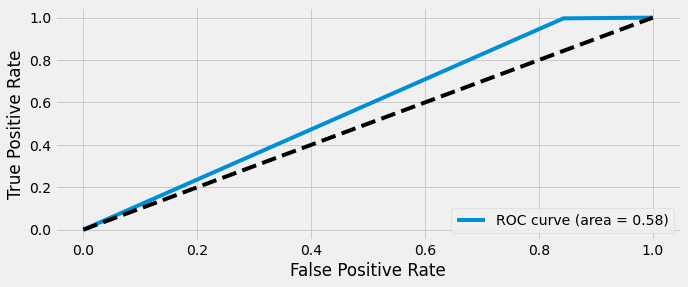

In [ ]:
fpr, tpr, _ = roc_curve(y_test, y_pred_svm)
roc_auc = auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
pass

In [ ]:

pprint(classification_report(y_true=y_test, y_pred=y_pred_svm))

('              precision    recall  f1-score   support\n'
 '\n'
 '           0       0.80      0.16      0.26        51\n'
 '           1       0.93      1.00      0.96       579\n'
 '\n'
 '    accuracy                           0.93       630\n'
 '   macro avg       0.87      0.58      0.61       630\n'
 'weighted avg       0.92      0.93      0.91       630\n')


In [ ]:
print("Training accuracy :", model.score(x_train, y_train))
print("Testing accuracy", model.score(x_test, y_test))

Training accuracy : 0.9527777777777777
Testing accuracy 0.9285714285714286


In [ ]:
from sklearn.ensemble import RandomForestClassifier

In [ ]:
rnd_clf = RandomForestClassifier()
rnd_clf.fit(x_train, y_train)
y_pred_rnd = rnd_clf.predict_proba(x_test)[:,1]

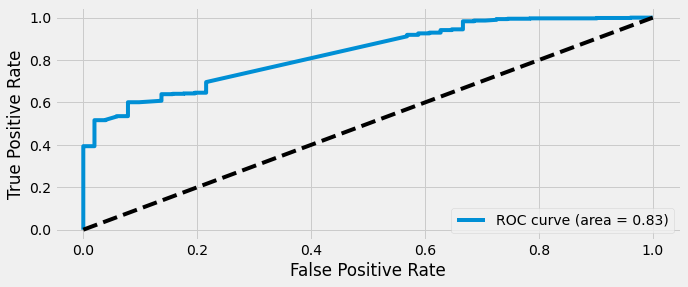

In [ ]:
fpr, tpr, _ = roc_curve(y_test, y_pred_rnd)
roc_auc = auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
pass

('              precision    recall  f1-score   support\n'
 '\n'
 '           0       0.74      0.27      0.40        51\n'
 '           1       0.94      0.99      0.96       579\n'
 '\n'
 '    accuracy                           0.93       630\n'
 '   macro avg       0.84      0.63      0.68       630\n'
 'weighted avg       0.92      0.93      0.92       630\n')


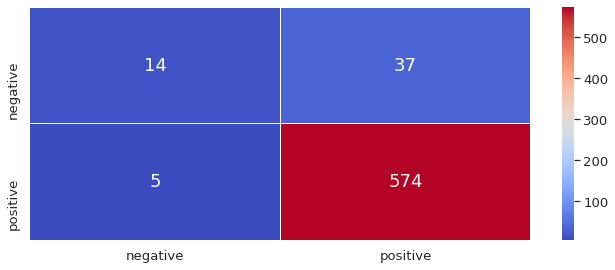

In [ ]:
y_scores_rnd = rnd_clf.predict(x_test)
pprint(classification_report(y_test, y_scores_rnd))
cm = confusion_matrix(y_test, y_scores_rnd)
labels = ['negative', 'positive']
df_cm = ["negative", "positive"]
df_cm = pd.DataFrame(cm, index=labels, columns=labels)
# config plot sizes
sns.set(font_scale=1.2)
sns.heatmap(df_cm, annot=True, annot_kws={"size": 18}, cmap='coolwarm', linewidth=0.5, fmt="")